In [2]:
import pandas as pd

In [6]:
df = pd.read_csv('df_0929_ver_1.csv')
print(df.head(1))

     store_id store_address store_name brand_code industry   open_date  \
0  16184E93D9    서울 성동구 마장동       성우**        NaN      축산물  20130320.0   

   close_date  ref_year_month operation_months_range sales_amount_range  ...  \
0         NaN          202405               2_10-25%           3_25-50%  ...   

  nearest_bus_lat nearest_bus_lon nearest_bus_dist_km nearest_subway  \
0       37.567063      127.044643            0.096983             마장   

   nearest_subway_lat  nearest_subway_lon  nearest_subway_dist_km  \
0             37.5661          127.042973                0.209686   

   nearest_subway_passengers  bus_200m_count  subway_500m_count  
0               11287.552632               3                  1  

[1 rows x 59 columns]


In [7]:
store_features = pd.read_csv('1002_store_features.csv')
print(store_features.head(1))

     store_id  is_closed business_district region_3depth_name    industry  \
0  000F03E44A      False                뚝섬              성수동1가  중식-딤섬/중식만두   

  industry_group        store_address store_name brand_code          x  ...  \
0             중식  서울특별시 성동구 왕십리로4가길 9       육육**        NaN  127.04636  ...   

   industry_emb_17 industry_emb_18 industry_emb_19  industry_emb_20  \
0        -0.032721        0.160167        0.005362         0.094463   

   static_cluster  exp1_industry_cluster  exp1_final_cluster  \
0              11                      5                   3   

   exp2_industry_cluster  exp2_final_cluster  district_rank_encoding  
0                      5                   0               32.206667  

[1 rows x 440 columns]


In [8]:
# ==============================================================================
# 데이터 병합 및 전처리
# ==============================================================================
# 1. 클러스터 ID 컬럼 이름 변경 (가독성을 위해)
store_features.rename(columns={'static_cluster': 'cluster_id'}, inplace=True)

# 2. store_features에서 필요한 정보(cluster_id)를 df에 병합(merge)
df_merged = pd.merge(
    df,
    store_features[['store_id', 'cluster_id']],
    on='store_id',
    how='left'
)

# 3. 월(month) 순서를 나타내는 컬럼 생성 (이벤트 생성 함수에서 사용)
df_merged['month_order'] = df_merged.groupby('store_id').cumcount() + 1


In [9]:
# 1. 계산을 위해 시간 순서대로 정확히 정렬합니다.
df_merged.sort_values(by=['store_id', 'ref_year_month'], inplace=True)

#
df_merged['rank_change'] = df_merged.groupby('store_id')['industry_sales_rank_ratio'].diff()
df_merged['district_rank_change'] = df_merged.groupby('store_id')['district_sales_rank_ratio'].diff()

# 1차 시도

In [10]:
# ==============================================================================
# 이벤트 생성 함수 정의
# ==============================================================================

def generate_event(row):
    events = []

    # --- 범용 이벤트 (순위 변화 기준) ---
    if row['rank_change'] > 5:
        events.append('업종내순위_악화')
    elif row['rank_change'] < -5:
        events.append('업종내순위_개선')

    # --- 핵심 위험 이벤트  ---
    # C0: 정통 한식 - 핵심 고객층(40대 남성) 이탈
    if row['cluster_id'] == 0 and row['male_40_ratio'] < 9.0:
        events.append('C0_핵심고객_이탈')

    # C2: 백반/가정식 - 초기 우위 상실 (순위 악화로 근사)
    # district_sales_rank_ratio_deterioration_count는 집계 지표이므로, 월별 순위가 크게 악화되는 현상으로 대체
    if row['cluster_id'] == 2 and row['district_rank_change'] > 15: # 15%p 이상 순위 악화 시
        events.append('C2_초기우위_상실의심')

    # C3: 소규모 분식 - 고객 구성 왜곡 (30대 남성 비중의 급격한 월별 증가로 근사)
    # male_30_ratio_start_end_diff는 집계 지표이므로, 전달 대비 비중 급증으로 대체
    if row['cluster_id'] == 3:
        # 이 규칙을 위해서는 'male_30_ratio_change' 컬럼이 사전에 계산되어야 합니다.
        # 예: df_merged['male_30_ratio_change'] = df_merged.groupby('store_id')['male_30_ratio'].diff()
        # 만약 해당 컬럼이 있다면 아래 주석을 해제하세요.
        # if row['male_30_ratio_change'] > 1.5:
        #    events.append('C3_고객구성_왜곡')
        # 대안: 30대 남성 비율이 비정상적으로 높은 경우
        if row['male_30_ratio'] > 20.0: # (예시 임계값, 데이터 분포를 보고 조정 필요)
            events.append('C3_고객구성_왜곡')

    # C5: 소형 커피 - 초기 고객 확보 실패 및 단골 부재
    if row['cluster_id'] == 5:
        if row['month_order'] <= 3 and row['female_30_ratio'] < 14.0:
            events.append('C5_초기핵심고객_부재')
        if row['month_order'] > 6 and row['returning_customer_ratio'] < 25.0:
            events.append('C5_단골확보_실패')

    # C7: 대형 카페 - 내부 경쟁력 상실 의심
    if row['cluster_id'] == 7 and row['industry_closure_ratio'] < 15.5:
        events.append('C7_내부경쟁력_상실의심')

    # C8: 마장동 시장 - 상권 환경 적응 실패 (상권 폐업률의 급격한 월별 감소로 근사)
    # district_closure_ratio_start_end_diff는 집계 지표이므로, 전달 대비 변화량으로 대체
    if row['cluster_id'] == 8:
        # 이 규칙을 위해서는 'district_closure_ratio_change' 컬럼이 사전에 계산되어야 합니다.
        # 예: df_merged['district_closure_ratio_change'] = df_merged.groupby('store_id')['district_closure_ratio'].diff()
        # 만약 해당 컬럼이 있다면 아래 주석을 해제하세요.
        # if row['district_closure_ratio_change'] < -0.5:
        #    events.append('C8_상권적응_실패의심')
        # 대안: 상권 폐업률이 매우 낮은데(안정적인데), 업종 내 순위가 악화될 경우
        if row['district_closure_ratio'] < 5.0 and row['rank_change'] > 5:
             events.append('C8_상권적응_실패의심')

    # C9: 단일 양식당 - 비정상적 운영 변동성 (순위 변동폭으로 근사)
    if row['cluster_id'] == 9 and abs(row['district_rank_change']) > 20: # 순위 변동폭이 20%p 이상일 때
        events.append('C9_운영_변동성_과다')

    # C10: 치킨/주류 - 장기 저항력 부족 (핵심 타겟 고객 설정 오류)
    if row['cluster_id'] == 10 and row['male_20_under_ratio'] > 20.0:
        events.append('C10_타겟고객_설정오류')

    if not events:
        return '일상'
    else:
        return '-'.join(sorted(events))


In [11]:
# ==============================================================================
# 함수 적용 및 최종 시퀀스 데이터셋 생성
# ==============================================================================
# 1. 이벤트 생성
df_merged['event'] = df_merged.apply(generate_event, axis=1)

# 2. 가맹점별 시퀀스 생성
sequences = df_merged.groupby('store_id')['event'].apply(list).reset_index()
sequences.rename(columns={'event': 'event_sequence'}, inplace=True)

# 3. '폐업' 이벤트 추가
# is_closed 컬럼을 사용해 폐업한 가맹점 목록을 만듭니다.
closed_stores = set(df_merged[df_merged['is_closed'] == True]['store_id'])

sequences['event_sequence'] = sequences.apply(
    lambda row: row['event_sequence'] + ['폐업'] if row['store_id'] in closed_stores else row['event_sequence'],
    axis=1
)

# 최종 결과 확인
print("--- 최종 시퀀스 데이터셋 ---")
print(sequences.head())

--- 최종 시퀀스 데이터셋 ---
     store_id                                     event_sequence
0  000F03E44A  [일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일...
1  002816BA73  [일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일...
2  003473B465  [일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일...
3  003AC99735  [일상, 일상, 일상, C5_초기핵심고객_부재, 일상, 일상, 일상, 일상, 일상,...
4  0041E4E5AE  [일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일...


In [14]:
# 마지막 이벤트가 폐업인지 여부 컬럼 추가
sequences['is_closed'] = sequences['event_sequence'].apply(
    lambda seq: seq[-1] == '폐업' if len(seq) > 0 else False
)

# 일상이 아닌 이벤트 비율 계산 함수 (앞서 만든 것 재사용)
def calc_non_daily_ratio(events):
    total = len(events)
    non_daily = sum(e != '일상' for e in events)
    return non_daily / total if total > 0 else 0

sequences['non_daily_ratio'] = sequences['event_sequence'].apply(calc_non_daily_ratio)

# 그룹별 통계 보기
group_stats = sequences.groupby('is_closed')['non_daily_ratio'].describe()
print(group_stats)


            count      mean       std   min      25%       50%       75%  max
is_closed                                                                    
False      4056.0  0.183463  0.273560  0.00  0.00000  0.041667  0.235294  1.0
True        127.0  0.304161  0.328377  0.04  0.04881  0.166667  0.477273  1.0


In [23]:
store_id = '000F03E44A'

# 해당 store의 event_sequence 꺼내기
events = sequences.loc[sequences['store_id'] == store_id, 'event_sequence'].iloc[0]

# 리스트를 Series로 변환해서 count
pd.Series(events).value_counts()


,count
일상,24


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. 모든 이벤트를 모아 고유한 이벤트 사전을 만듭니다.
all_events = set(event for seq in sequences['event_sequence'] for event in seq)
event2idx = {event: i + 1 for i, event in enumerate(all_events)} # 0은 패딩을 위해 남겨둠
idx2event = {i + 1: event for i, event in enumerate(all_events)}

# '폐업' 이벤트의 번호를 따로 저장해 둡니다.
closure_idx = event2idx['폐업']
vocab_size = len(event2idx) + 1 # 패딩 포함한 전체 사전 크기

# 2. 모든 시퀀스를 정수(Integer)로 변환합니다.
encoded_sequences = [
    [event2idx[event] for event in seq]
    for seq in sequences['event_sequence']
]

# 3. 모든 시퀀스의 길이를 통일합니다 (Padding).
max_len = max(len(seq) for seq in encoded_sequences)
padded_sequences = pad_sequences(encoded_sequences, maxlen=max_len, padding='pre')

print("--- 정수 인코딩 및 패딩 완료 ---")
print("원본 시퀀스:", encoded_sequences[1])
print("패딩된 시퀀스:", padded_sequences[1])

--- 정수 인코딩 및 패딩 완료 ---
원본 시퀀스: [12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]
패딩된 시퀀스: [ 0 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12]


In [ ]:
import numpy as np

X = [] # 모델에 들어갈 입력 데이터
y = [] # 모델이 맞춰야 할 정답 데이터

for seq in padded_sequences:
    for i in range(1, len(seq)):
        # 0이 아닌 부분까지만 학습 데이터를 생성
        if seq[i] == 0:
            continue
        X.append(seq[:i])
        y.append(seq[i])

X = pad_sequences(X, maxlen=max_len, padding='pre')
y = np.array(y)

print("\n--- 학습 데이터셋 생성 ---")
print("입력 데이터 예시 (X):", X[-3:])
print("정답 데이터 예시 (y):", y[-3:])


--- 학습 데이터셋 생성 ---
입력 데이터 예시 (X): [[ 0  0  0  0 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
  12]
 [ 0  0  0 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
  12]
 [ 0  0 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
  12]]
정답 데이터 예시 (y): [12 12 12]


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense

# ==============================================================================
# 모델 정의
# ==============================================================================
# 모델의 각 층(Layer)을 순서대로 쌓아 만듭니다.

model = Sequential([
    # 1. Embedding Layer
    # 단어(이벤트)를 벡터로 변환하는 층입니다.
    # 모델이 이벤트 간의 의미적 관계를 학습하는 공간입니다.
    # input_dim: 전체 이벤트의 개수 (패딩 포함)
    # output_dim: 각 단어를 몇 차원의 벡터로 표현할지 (보통 64, 128 등)
    # input_length: 입력 시퀀스의 길이
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len),

    # 2. GRU Layer (Recurrent Neural Network)
    # 시퀀스 데이터의 시간적 패턴(순서)을 학습하는 핵심 층입니다.
    # units: GRU 레이어의 뉴런 수
    GRU(units=128),

    # 3. Dense Layer (Output Layer)
    # GRU에서 처리된 결과를 바탕으로 최종 예측을 수행합니다.
    # units: vocab_size -> 예측해야 할 이벤트의 총 개수
    # activation='softmax': 모든 이벤트에 대한 확률을 출력하여, 총합이 1이 되도록 만듭니다.
    Dense(units=vocab_size, activation='softmax')
])


# ==============================================================================
# 모델 컴파일
# ==============================================================================
# 모델을 어떻게 학습시킬지 설정합니다.
model.compile(
    optimizer='adam',  # 가장 일반적으로 사용되는 최적화 알고리즘
    loss='sparse_categorical_crossentropy', # 정수 형태의 정답(y)을 다룰 때 사용하는 손실 함수
    metrics=['accuracy'] # 학습 과정을 평가할 지표
)

# 모델의 전체 구조를 확인합니다.
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ==============================================================================
# 모델 학습
# ==============================================================================
# epochs: 전체 데이터셋을 몇 번 반복해서 학습할지
# batch_size: 한 번에 몇 개의 데이터를 묶어서 처리할지
history = model.fit(
    X,
    y,
    epochs=10,
    batch_size=64,
    validation_split=0.2 # 데이터의 20%를 검증용으로 사용
)

# 이제 'model'은 학습이 완료된 상태입니다.
# 이 모델을 사용하여 이전 단계에서 설명한 것처럼 '폐업 위험도'를 예측할 수 있습니다.

Epoch 1/10
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 48s 42ms/step - accuracy: 0.9012 - loss: 0.5184 - val_accuracy: 0.9230 - val_loss: 0.3040
Epoch 2/10
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 82s 42ms/step - accuracy: 0.9247 - loss: 0.2884 - val_accuracy: 0.9255 - val_loss: 0.2850
Epoch 3/10
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 44s 41ms/step - accuracy: 0.9266 - loss: 0.2786 - val_accuracy: 0.9256 - val_loss: 0.2809
Epoch 4/10
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - accuracy: 0.9287 - loss: 0.2688 - val_accuracy: 0.9276 - val_loss: 0.2761
Epoch 5/10
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - accuracy: 0.9292 - loss: 0.2623 - val_accuracy: 0.9273 - val_loss: 0.2725
Epoch 6/10
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - accuracy: 0.9299 - loss: 0.2602 - val_accuracy: 0.9277 - val_loss: 0.2679
Epoch 7/10
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - accuracy: 0.9292 - loss: 0.2574 - val_accuracy: 0.9271 - val_loss: 0.2670
Epoch 8/10
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 35s 32ms/step - accuracy: 0.9288 -

542/542 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step
--- '폐업' 클래스 성능 평가 ---
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     17295
        True       1.00      0.42      0.59        26

    accuracy                           1.00     17321
   macro avg       1.00      0.71      0.80     17321
weighted avg       1.00      1.00      1.00     17321



/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51316 (\N{HANGUL SYLLABLE JON}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54224 (\N{HANGUL SYLLABLE PYE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/u

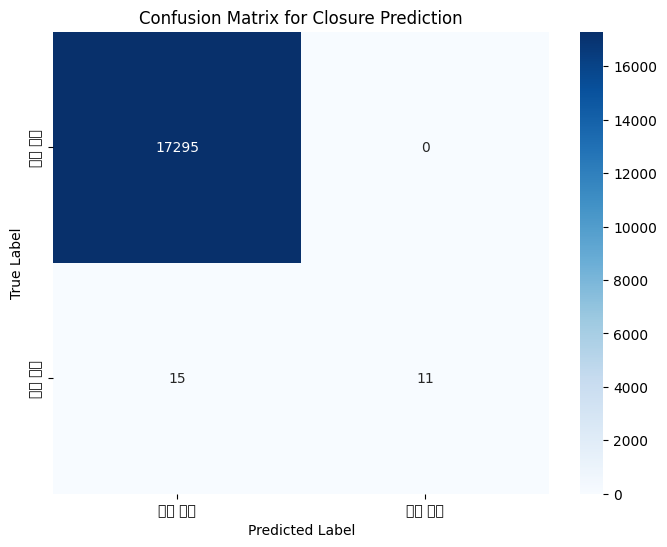

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. 검증 데이터 준비
# model.fit에서 validation_split=0.2로 설정했으므로, X와 y의 마지막 20%가 검증 데이터입니다.
split_point = int(len(X) * 0.8)
X_val, y_val = X[split_point:], y[split_point:]

# 2. 검증 데이터에 대한 예측 수행
# model.predict는 각 이벤트에 대한 확률을 출력하므로, 가장 확률이 높은 이벤트를 예측값으로 선택합니다.
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# 3. '폐업' 클래스에 대한 성능만 집중적으로 확인
# closure_idx는 '폐업' 이벤트의 번호입니다.
print("--- '폐업' 클래스 성능 평가 ---")
print(classification_report(y_val == closure_idx, y_pred == closure_idx))

# 4. 혼동 행렬 시각화
cm = confusion_matrix(y_val == closure_idx, y_pred == closure_idx)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['생존 예측', '폐업 예측'], yticklabels=['실제 생존', '실제 폐업'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Closure Prediction')
plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ==============================================================================
# [1. 예측 함수 정의] - 이 부분을 먼저 실행해야 합니다.
# ==============================================================================
def predict_closure_risk(store_sequence_str, model, event2idx, max_len, closure_idx):
    """
    가맹점의 이벤트 시퀀스(문자열 리스트)를 입력받아
    학습된 모델을 기반으로 폐업 위험도를 반환합니다.
    """
    # 1. Integer Encoding: 문자열 이벤트를 숫자로 변환합니다.
    encoded_sequence = [event2idx.get(event, 0) for event in store_sequence_str]

    # 2. Padding: 모델의 입력 길이에 맞게 시퀀스 길이를 통일합니다.
    padded_sequence = pad_sequences([encoded_sequence], maxlen=max_len, padding='pre')

    # 3. Predict: 모델을 사용해 다음 이벤트 확률을 예측합니다.
    prediction_probabilities = model.predict(padded_sequence, verbose=0)[0]

    # 4. Extract Risk Score: 전체 확률 배열에서 '폐업' 이벤트의 확률만 추출합니다.
    risk_score = prediction_probabilities[closure_idx]

    return risk_score


# ==============================================================================
# [2. 함수를 사용하여 위험도 계산 및 랭킹 생성] - 이제 오류 없이 실행됩니다.
# ==============================================================================
# 1. 운영 중인 가맹점의 시퀀스만 필터링
active_stores_df = sequences[~sequences['event_sequence'].apply(lambda x: '폐업' in x)].copy()

# 2. 각 가맹점의 위험도를 계산하여 저장
active_stores_df['risk_score'] = active_stores_df['event_sequence'].apply(
    lambda seq: predict_closure_risk(seq, model, event2idx, max_len, closure_idx)
)

# 3. 위험도가 높은 순서대로 정렬
risk_ranking = active_stores_df.sort_values(by='risk_score', ascending=False)

# 4. 상위 5개 위험 가맹점의 상세 내역 확인
print("\n--- 🚨 상위 5개 위험 가맹점 상세 분석 ---")
for index, row in risk_ranking.head(5).iterrows():
    store_id = row['store_id']
    risk_score = row['risk_score']
    event_sequence = row['event_sequence']

    print(f"\n[가맹점 ID: {store_id}]")
    print(f"  - 폐업 위험도: {risk_score*100:.2f}%")
    print(f"  - 이벤트 시퀀스: {' -> '.join(event_sequence)}")


--- 🚨 상위 5개 위험 가맹점 상세 분석 ---

[가맹점 ID: 9218EE2A57]
  - 폐업 위험도: 99.84%
  - 이벤트 시퀀스: C7_내부경쟁력_상실의심 -> 일상 -> 일상 -> 일상 -> 일상 -> 일상 -> 일상 -> 일상 -> 일상 -> 일상 -> C7_내부경쟁력_상실의심 -> C7_내부경쟁력_상실의심 -> C7_내부경쟁력_상실의심 -> C7_내부경쟁력_상실의심 -> C7_내부경쟁력_상실의심 -> C7_내부경쟁력_상실의심 -> C7_내부경쟁력_상실의심 -> C7_내부경쟁력_상실의심 -> C7_내부경쟁력_상실의심 -> C7_내부경쟁력_상실의심 -> C7_내부경쟁력_상실의심 -> C7_내부경쟁력_상실의심 -> C7_내부경쟁력_상실의심 -> 일상

[가맹점 ID: 9972114004]
  - 폐업 위험도: 99.84%
  - 이벤트 시퀀스: C7_내부경쟁력_상실의심 -> 일상 -> 일상 -> 일상 -> 일상 -> 일상 -> 일상 -> 일상 -> 일상 -> 일상 -> C7_내부경쟁력_상실의심 -> C7_내부경쟁력_상실의심 -> C7_내부경쟁력_상실의심 -> C7_내부경쟁력_상실의심 -> C7_내부경쟁력_상실의심 -> C7_내부경쟁력_상실의심 -> C7_내부경쟁력_상실의심 -> C7_내부경쟁력_상실의심 -> C7_내부경쟁력_상실의심 -> C7_내부경쟁력_상실의심 -> C7_내부경쟁력_상실의심 -> C7_내부경쟁력_상실의심 -> C7_내부경쟁력_상실의심 -> 일상

[가맹점 ID: BCA89C9A13]
  - 폐업 위험도: 99.84%
  - 이벤트 시퀀스: C7_내부경쟁력_상실의심 -> 일상 -> 일상 -> 일상 -> 일상 -> 일상 -> 일상 -> 일상 -> 일상 -> 일상 -> C7_내부경쟁력_상실의심 -> C7_내부경쟁력_상실의심 -> C7_내부경쟁력_상실의심 -> C7_내부경쟁력_상실의심 -> C7_내부경쟁력_상실의심 -> C7_내부경쟁력_상실의심 -> C7_내부경쟁력_상실의심 -> C7_내부경쟁력_상실의심 -> C7_내부경쟁력_상실

# 2차 시도

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
def generate_event_upgraded(row):
    events = []

    # --- 범용 이벤트 (세분화) ---
    if row['rank_change'] > 15:
        events.append('업종내순위_대폭악화')
    elif row['rank_change'] > 5:
        events.append('업종내순위_소폭악화')

    if row['district_rank_change'] > 15:
        events.append('상권내순위_대폭악화')
    elif row['district_rank_change'] > 5:
        events.append('상권내순위_소폭악화')

    # --- 핵심 위험 이벤트 (인사이트 기반 고도화 및 다중 적용) ---

    # C0: 정통 한식
    if row['cluster_id'] == 0:
        if row['male_40_ratio'] < 9.0: # 폐업점 평균(8.7) 근사
            events.append('C0_핵심고객_이탈')
        if row['district_closure_ratio'] > 9.0: # 폐업점 평균(9.3) 근사
            events.append('C0_주변상권_위험')

    # C2: 백반/가정식
    if row['cluster_id'] == 2:
        # '초기 우위 상실' 근사: 초반 6개월 내 상권 순위 대폭 악화
        if row['month_order'] <= 6 and row['district_rank_change'] > 15:
            events.append('C2_초기우위_상실의심')
        # '고객 기반 확보 실패' 근사: 30대 여성 비율이 매우 낮을 때
        if row['female_30_ratio'] < 10.0:
            events.append('C2_고객기반_부실')

    # C3: 소규모 분식
    if row['cluster_id'] == 3 and row['male_30_ratio'] > 15.0: # 생존점 평균보다 훨씬 높은 수준
        events.append('C3_고객구성_왜곡')

    # C5: 소형 커피
    if row['cluster_id'] == 5:
        if row['month_order'] <= 3 and row['female_30_ratio'] < 14.0: # 조기경보 트리거
            events.append('C5_초기핵심고객_부재')
        if row['month_order'] > 6 and row['returning_customer_ratio'] < 25.0: # 폐업점 평균(22.4) 근사
            events.append('C5_단골확보_실패')
        if row['rank_change'] > 0: # 생존점은 순위가 개선(-7.6)되나 폐업점은 악화(+3.5)
            events.append('C5_경쟁력_악화')

    # C7: 대형 카페
    if row['cluster_id'] == 7:
        # 경쟁 완화에도 성과가 낮은 상황 (복합 이벤트)
        if row['industry_closure_ratio'] < 16.0 and row['rank_change'] > 0:
            events.append('C7_내부역량_부족의심')

    # C8: 마장동 시장
    if row['cluster_id'] == 8:
        # 상권 안정화에도 성과가 낮은 상황 (복합 이벤트)
        if row['district_closure_ratio'] < 5.0 and row['rank_change'] > 5:
            events.append('C8_상권적응_실패의심')

    # C9: 단일 양식당
    if row['cluster_id'] == 9:
        if abs(row['district_rank_change']) > 20:
            events.append('C9_운영_변동성_과다')
        # 주변 상권 불안정성에 노출
        if row['district_closure_ratio'] > 10.0: # (임계값 예시)
            events.append('C9_상권_불안정')

    # C10: 치킨/주류
    if row['cluster_id'] == 10:
        if row['male_20_under_ratio'] > 20.0: # 폐업점 평균(21.4) 근사
            events.append('C10_타겟고객_설정오류')
        if row['delivery_sales_ratio'] < 30.0: # 배달 비중이 낮을 경우 (임계값 예시)
            events.append('C10_배달경쟁력_부족')

    if not events:
        events.append('일상')

    return events # 최종적으로 이벤트 '리스트'를 반환


In [ ]:
# --- 데이터 처리부터 모델 학습까지 ---

# 1. 사전 계산 컬럼 추가
df_merged.sort_values(by=['store_id', 'ref_year_month'], inplace=True)
df_merged['rank_change'] = df_merged.groupby('store_id')['industry_sales_rank_ratio'].diff()
df_merged['district_rank_change'] = df_merged.groupby('store_id')['district_sales_rank_ratio'].diff()

# 2. 새로운 이벤트 생성 함수 적용
df_merged['event_list'] = df_merged.apply(generate_event_upgraded, axis=1)

# 3. 가맹점별 시퀀스 생성 (이벤트 리스트를 하나의 긴 리스트로 펼침)
sequences_df = df_merged.groupby('store_id')['event_list'].apply(lambda lists: [event for sublist in lists for event in sublist]).reset_index()
sequences_df.rename(columns={'event_list': 'event_sequence'}, inplace=True)

# '폐업' 이벤트 추가
closed_stores = set(df_merged[df_merged['is_closed'] == True]['store_id'])
sequences_df['event_sequence'] = sequences_df.apply(
    lambda row: row['event_sequence'] + ['폐업'] if row['store_id'] in closed_stores else row['event_sequence'],
    axis=1
)

# 4. 데이터 전처리 및 학습셋 생성
all_events = set(event for seq in sequences_df['event_sequence'] for event in seq)
event2idx = {event: i + 1 for i, event in enumerate(all_events)}
idx2event = {i + 1: event for i, event in enumerate(all_events)}
closure_idx = event2idx.get('폐업', -1) # 폐업 이벤트가 없을 경우 오류 방지
vocab_size = len(event2idx) + 1

encoded_sequences = [[event2idx[event] for event in seq] for seq in sequences_df['event_sequence']]
max_len = max(len(seq) for seq in encoded_sequences)
padded_sequences = pad_sequences(encoded_sequences, maxlen=max_len, padding='pre')

X, y = [], []
for seq in padded_sequences:
    for i in range(1, len(seq)):
        if seq[i] == 0: continue
        X.append(seq[:i])
        y.append(seq[i])

X = pad_sequences(X, maxlen=max_len, padding='pre')
y = np.array(y)


In [ ]:
# 5. 모델 정의 및 학습 (이전과 동일)
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len),
    GRU(units=128),
    Dense(units=vocab_size, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X, y, epochs=10, batch_size=64, validation_split=0.2)


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1109/1109 ━━━━━━━━━━━━━━━━━━━━ 83s 73ms/step - accuracy: 0.8788 - loss: 0.5722 - val_accuracy: 0.9163 - val_loss: 0.3170
Epoch 2/10
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 75s 68ms/step - accuracy: 0.9198 - loss: 0.3091 - val_accuracy: 0.9209 - val_loss: 0.3031
Epoch 3/10
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 71s 64ms/step - accuracy: 0.9223 - loss: 0.2996 - val_accuracy: 0.9225 - val_loss: 0.2992
Epoch 4/10
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 82s 64ms/step - accuracy: 0.9235 - loss: 0.2937 - val_accuracy: 0.9229 - val_loss: 0.2913
Epoch 5/10
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 71s 64ms/step - accuracy: 0.9258 - loss: 0.2864 - val_accuracy: 0.9251 - val_loss: 0.2890
Epoch 6/10
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 82s 64ms/step - accuracy: 0.9278 - loss: 0.2797 - val_accuracy: 0.9251 - val_loss: 0.2847
Epoch 7/10
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 71s 64ms/step - accuracy: 0.9259 - loss: 0.2835 - val_accuracy: 0.9273 - val_loss: 0.2831
Epoch 8/10
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 71s 64ms/step - accuracy: 0.9291 - loss: 0.27

555/555 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step


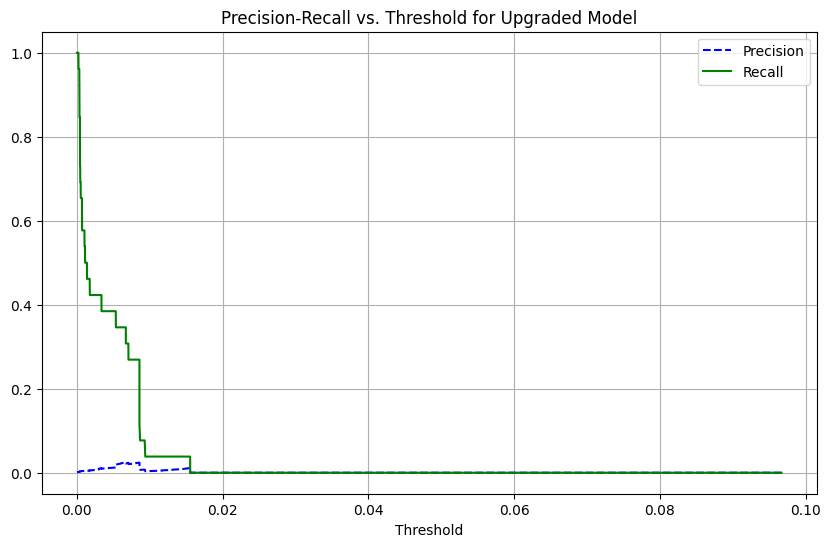

최적 임계값 (Best F1-score): 0.0067

--- 최적 임계값 적용 후 성능 평가 ---
              precision    recall  f1-score   support

       False       1.00      0.98      0.99     17709
        True       0.02      0.35      0.05        26

    accuracy                           0.98     17735
   macro avg       0.51      0.66      0.52     17735
weighted avg       1.00      0.98      0.99     17735



In [ ]:
# 최적 임계점 탐색 및 최종 성능 평가

split_point = int(len(X) * 0.8)
X_val, y_val = X[split_point:], y[split_point:]

# '폐업' 클래스의 예측 확률만 추출
y_pred_probs = model.predict(X_val)[:, closure_idx]

# Precision-Recall 커브 계산 및 시각화
precisions, recalls, thresholds = precision_recall_curve(y_val == closure_idx, y_pred_probs)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.legend()
plt.title("Precision-Recall vs. Threshold for Upgraded Model")
plt.grid(True)
plt.show()

# F1-score가 최대가 되는 지점의 임계값을 찾아 적용
f1_scores = 2 * recalls * precisions / (recalls + precisions + 1e-10) # 0으로 나누는 것 방지
best_threshold = thresholds[np.argmax(f1_scores[:-1])]
print(f"최적 임계값 (Best F1-score): {best_threshold:.4f}")

# 최적 임계값으로 최종 성능 다시 확인
final_pred = (y_pred_probs >= best_threshold).astype(int)
print("\n--- 최적 임계값 적용 후 성능 평가 ---")
print(classification_report(y_val == closure_idx, final_pred))


# 3차 시도

In [ ]:
# ==============================================================================
# 이벤트 생성 함수 정의
# ==============================================================================

def generate_event(row):
    events = []

    # --- 범용 이벤트 (순위 변화 기준) ---
    if row['rank_change'] > 5:
        events.append('업종내순위_악화')
    elif row['rank_change'] < -5:
        events.append('업종내순위_개선')

    # --- 핵심 위험 이벤트  ---
    # C0: 정통 한식 - 핵심 고객층(40대 남성) 이탈
    if row['cluster_id'] == 0 and row['male_40_ratio'] < 9.0:
        events.append('C0_핵심고객_이탈')

    # C2: 백반/가정식 - 초기 우위 상실 (순위 악화로 근사)
    # district_sales_rank_ratio_deterioration_count는 집계 지표이므로, 월별 순위가 크게 악화되는 현상으로 대체
    if row['cluster_id'] == 2 and row['district_rank_change'] > 15: # 15%p 이상 순위 악화 시
        events.append('C2_초기우위_상실의심')

    # C3: 소규모 분식 - 고객 구성 왜곡 (30대 남성 비중의 급격한 월별 증가로 근사)
    # male_30_ratio_start_end_diff는 집계 지표이므로, 전달 대비 비중 급증으로 대체
    if row['cluster_id'] == 3:
        # 이 규칙을 위해서는 'male_30_ratio_change' 컬럼이 사전에 계산되어야 합니다.
        # 예: df_merged['male_30_ratio_change'] = df_merged.groupby('store_id')['male_30_ratio'].diff()
        # 만약 해당 컬럼이 있다면 아래 주석을 해제하세요.
        # if row['male_30_ratio_change'] > 1.5:
        #    events.append('C3_고객구성_왜곡')
        # 대안: 30대 남성 비율이 비정상적으로 높은 경우
        if row['male_30_ratio'] > 20.0: # (예시 임계값, 데이터 분포를 보고 조정 필요)
            events.append('C3_고객구성_왜곡')

    # C5: 소형 커피 - 초기 고객 확보 실패 및 단골 부재
    if row['cluster_id'] == 5:
        if row['month_order'] <= 3 and row['female_30_ratio'] < 14.0:
            events.append('C5_초기핵심고객_부재')
        if row['month_order'] > 6 and row['returning_customer_ratio'] < 25.0:
            events.append('C5_단골확보_실패')

    # C7: 대형 카페 - 내부 경쟁력 상실 의심
    if row['cluster_id'] == 7 and row['industry_closure_ratio'] < 15.5:
        events.append('C7_내부경쟁력_상실의심')

    # C8: 마장동 시장 - 상권 환경 적응 실패 (상권 폐업률의 급격한 월별 감소로 근사)
    # district_closure_ratio_start_end_diff는 집계 지표이므로, 전달 대비 변화량으로 대체
    if row['cluster_id'] == 8:
        # 이 규칙을 위해서는 'district_closure_ratio_change' 컬럼이 사전에 계산되어야 합니다.
        # 예: df_merged['district_closure_ratio_change'] = df_merged.groupby('store_id')['district_closure_ratio'].diff()
        # 만약 해당 컬럼이 있다면 아래 주석을 해제하세요.
        # if row['district_closure_ratio_change'] < -0.5:
        #    events.append('C8_상권적응_실패의심')
        # 대안: 상권 폐업률이 매우 낮은데(안정적인데), 업종 내 순위가 악화될 경우
        if row['district_closure_ratio'] < 5.0 and row['rank_change'] > 5:
             events.append('C8_상권적응_실패의심')

    # C9: 단일 양식당 - 비정상적 운영 변동성 (순위 변동폭으로 근사)
    if row['cluster_id'] == 9 and abs(row['district_rank_change']) > 20: # 순위 변동폭이 20%p 이상일 때
        events.append('C9_운영_변동성_과다')

    # C10: 치킨/주류 - 장기 저항력 부족 (핵심 타겟 고객 설정 오류)
    if row['cluster_id'] == 10 and row['male_20_under_ratio'] > 20.0:
        events.append('C10_타겟고객_설정오류')

    if not events:
        return '일상'
    else:
        return '-'.join(sorted(events))



In [ ]:
# ==============================================================================
# 함수 적용 및 최종 시퀀스 데이터셋 생성
# ==============================================================================
# 1. 이벤트 생성
df_merged['event'] = df_merged.apply(generate_event, axis=1)

# 2. 가맹점별 시퀀스 생성
sequences = df_merged.groupby('store_id')['event'].apply(list).reset_index()
sequences.rename(columns={'event': 'event_sequence'}, inplace=True)

# 3. '폐업' 이벤트 추가
# is_closed 컬럼을 사용해 폐업한 가맹점 목록을 만듭니다.
closed_stores = set(df_merged[df_merged['is_closed'] == True]['store_id'])

sequences['event_sequence'] = sequences.apply(
    lambda row: row['event_sequence'] + ['폐업'] if row['store_id'] in closed_stores else row['event_sequence'],
    axis=1
)

# 최종 결과 확인
print("--- 최종 시퀀스 데이터셋 ---")
print(sequences.head())


--- 최종 시퀀스 데이터셋 ---
     store_id                                     event_sequence
0  000F03E44A  [일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일...
1  002816BA73  [일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일...
2  003473B465  [일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일...
3  003AC99735  [일상, 일상, 일상, C5_초기핵심고객_부재, 일상, 일상, 일상, 일상, 일상,...
4  0041E4E5AE  [일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일...


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. 모든 이벤트를 모아 고유한 이벤트 사전을 만듭니다.
all_events = set(event for seq in sequences['event_sequence'] for event in seq)
event2idx = {event: i + 1 for i, event in enumerate(all_events)} # 0은 패딩을 위해 남겨둠
idx2event = {i + 1: event for i, event in enumerate(all_events)}

# '폐업' 이벤트의 번호를 따로 저장해 둡니다.
closure_idx = event2idx['폐업']
vocab_size = len(event2idx) + 1 # 패딩 포함한 전체 사전 크기

# 2. 모든 시퀀스를 정수(Integer)로 변환합니다.
encoded_sequences = [
    [event2idx[event] for event in seq]
    for seq in sequences['event_sequence']
]

# 3. 모든 시퀀스의 길이를 통일합니다 (Padding).
max_len = max(len(seq) for seq in encoded_sequences)
padded_sequences = pad_sequences(encoded_sequences, maxlen=max_len, padding='pre')

print("--- 정수 인코딩 및 패딩 완료 ---")
print("원본 시퀀스:", encoded_sequences[1])
print("패딩된 시퀀스:", padded_sequences[1])


--- 정수 인코딩 및 패딩 완료 ---
원본 시퀀스: [15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]
패딩된 시퀀스: [ 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15]


In [ ]:
import numpy as np

X = [] # 모델에 들어갈 입력 데이터
y = [] # 모델이 맞춰야 할 정답 데이터

for seq in padded_sequences:
    for i in range(1, len(seq)):
        # 0이 아닌 부분까지만 학습 데이터를 생성
        if seq[i] == 0:
            continue
        X.append(seq[:i])
        y.append(seq[i])

X = pad_sequences(X, maxlen=max_len, padding='pre')
y = np.array(y)

print("\n--- 학습 데이터셋 생성 ---")
print("입력 데이터 예시 (X):", X[-3:])
print("정답 데이터 예시 (y):", y[-3:])



--- 학습 데이터셋 생성 ---
입력 데이터 예시 (X): [[ 0  0  0  0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
  15]
 [ 0  0  0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
  15]
 [ 0  0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
  15]]
정답 데이터 예시 (y): [15 15 15]


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Embedding, MultiHeadAttention, LayerNormalization, Dense, GlobalAveragePooling1D
from tensorflow.keras.models import Model

# TransformerBlock 클래스 정의 (이전과 동일)
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# ==============================================================================
# Transformer 모델 조립 (수정된 부분 포함)
# ==============================================================================
# 모델 하이퍼파라미터
embed_dim = 64
num_heads = 4
ff_dim = 64

# 모델 정의
inputs = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)

# x = GlobalAveragePooling1D()            # <--- 이전 코드 (오류 발생)
x = GlobalAveragePooling1D()(x)         # <--- ⭐️ 수정된 코드: (x)를 추가하여 레이어를 통과시킵니다.

x = Dense(128, activation="relu")(x)
outputs = Dense(vocab_size, activation="softmax")(x)

# 최종 모델 생성
transformer_model = Model(inputs=inputs, outputs=outputs)

# 모델 컴파일
transformer_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 모델 구조 확인
transformer_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 25, 64)         │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ (None, 25, 64)         │        74,944 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 25)             │         3,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,089 (344.10 KB)

 Trainable params: 88,089 (344.10 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 이전에 생성해 둔 X와 y 데이터를 사용합니다.
history = transformer_model.fit(
    X,
    y,
    epochs=10,
    batch_size=64,
    validation_split=0.2 # 훈련 데이터의 20%를 검증용으로 사용
)

Epoch 1/10
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 53s 46ms/step - accuracy: 0.8882 - loss: 0.4518 - val_accuracy: 0.9148 - val_loss: 0.3120
Epoch 2/10
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 81s 45ms/step - accuracy: 0.9150 - loss: 0.3142 - val_accuracy: 0.9165 - val_loss: 0.3121
Epoch 3/10
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 47s 43ms/step - accuracy: 0.9164 - loss: 0.2982 - val_accuracy: 0.9136 - val_loss: 0.3056
Epoch 4/10
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 47s 43ms/step - accuracy: 0.9146 - loss: 0.3000 - val_accuracy: 0.9151 - val_loss: 0.2945
Epoch 5/10
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 50s 47ms/step - accuracy: 0.9169 - loss: 0.2889 - val_accuracy: 0.9161 - val_loss: 0.2944
Epoch 6/10
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 47s 43ms/step - accuracy: 0.9170 - loss: 0.2907 - val_accuracy: 0.9170 - val_loss: 0.2920
Epoch 7/10
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 81s 42ms/step - accuracy: 0.9174 - loss: 0.2889 - val_accuracy: 0.9174 - val_loss: 0.2903
Epoch 8/10
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 82s 43ms/step - accuracy: 0.9180 -

542/542 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


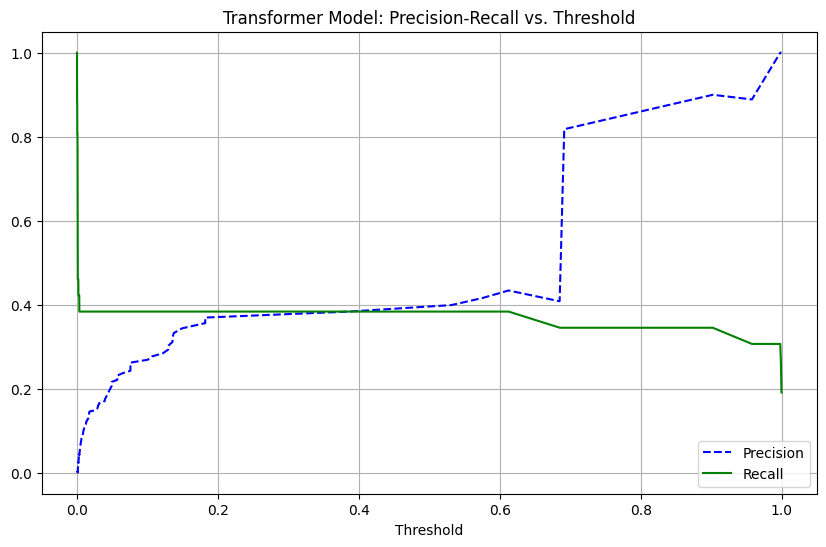

최적 임계값 (Best F1-score): 0.9019

--- Transformer 모델 최종 성능 평가 ---
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     17295
        True       0.90      0.35      0.50        26

    accuracy                           1.00     17321
   macro avg       0.95      0.67      0.75     17321
weighted avg       1.00      1.00      1.00     17321



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

# 1. 검증 데이터 준비
split_point = int(len(X) * 0.8)
X_val, y_val = X[split_point:], y[split_point:]

# 2. '폐업' 클래스의 예측 확률만 추출
y_pred_probs = transformer_model.predict(X_val)[:, closure_idx]

# 3. Precision-Recall 커브 계산 및 시각화
precisions, recalls, thresholds = precision_recall_curve(y_val == closure_idx, y_pred_probs)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.legend()
plt.title("Transformer Model: Precision-Recall vs. Threshold")
plt.grid(True)
plt.show()

# 4. F1-score가 최대가 되는 최적 임계값으로 최종 성능 확인
f1_scores = 2 * recalls * precisions / (recalls + precisions + 1e-10)
best_threshold = thresholds[np.argmax(f1_scores[:-1])]
print(f"최적 임계값 (Best F1-score): {best_threshold:.4f}")

final_pred = (y_pred_probs >= best_threshold).astype(int)
print("\n--- Transformer 모델 최종 성능 평가 ---")
print(classification_report(y_val == closure_idx, final_pred))

# 4. 처음 게 제일 좋앗다.. 다시...

In [ ]:
# ==============================================================================
# 이벤트 생성 함수 정의
# ==============================================================================

def generate_event(row):
    events = []

    # --- 범용 이벤트 (순위 변화 기준) ---
    if row['rank_change'] > 5:
        events.append('업종내순위_악화')
    elif row['rank_change'] < -5:
        events.append('업종내순위_개선')

    # --- 핵심 위험 이벤트  ---
    # C0: 정통 한식 - 핵심 고객층(40대 남성) 이탈
    if row['cluster_id'] == 0 and row['male_40_ratio'] < 9.0:
        events.append('C0_핵심고객_이탈')

    # C2: 백반/가정식 - 초기 우위 상실 (순위 악화로 근사)
    # district_sales_rank_ratio_deterioration_count는 집계 지표이므로, 월별 순위가 크게 악화되는 현상으로 대체
    if row['cluster_id'] == 2 and row['district_rank_change'] > 15: # 15%p 이상 순위 악화 시
        events.append('C2_초기우위_상실의심')

    # C3: 소규모 분식 - 고객 구성 왜곡 (30대 남성 비중의 급격한 월별 증가로 근사)
    # male_30_ratio_start_end_diff는 집계 지표이므로, 전달 대비 비중 급증으로 대체
    if row['cluster_id'] == 3:
        # 이 규칙을 위해서는 'male_30_ratio_change' 컬럼이 사전에 계산되어야 합니다.
        # 예: df_merged['male_30_ratio_change'] = df_merged.groupby('store_id')['male_30_ratio'].diff()
        # 만약 해당 컬럼이 있다면 아래 주석을 해제하세요.
        # if row['male_30_ratio_change'] > 1.5:
        #    events.append('C3_고객구성_왜곡')
        # 대안: 30대 남성 비율이 비정상적으로 높은 경우
        if row['male_30_ratio'] > 20.0: # (예시 임계값, 데이터 분포를 보고 조정 필요)
            events.append('C3_고객구성_왜곡')

    # C5: 소형 커피 - 초기 고객 확보 실패 및 단골 부재
    if row['cluster_id'] == 5:
        if row['month_order'] <= 3 and row['female_30_ratio'] < 14.0:
            events.append('C5_초기핵심고객_부재')
        if row['month_order'] > 6 and row['returning_customer_ratio'] < 25.0:
            events.append('C5_단골확보_실패')

    # C7: 대형 카페 - 내부 경쟁력 상실 의심
    if row['cluster_id'] == 7 and row['industry_closure_ratio'] < 15.5:
        events.append('C7_내부경쟁력_상실의심')

    # C8: 마장동 시장 - 상권 환경 적응 실패 (상권 폐업률의 급격한 월별 감소로 근사)
    # district_closure_ratio_start_end_diff는 집계 지표이므로, 전달 대비 변화량으로 대체
    if row['cluster_id'] == 8:
        # 이 규칙을 위해서는 'district_closure_ratio_change' 컬럼이 사전에 계산되어야 합니다.
        # 예: df_merged['district_closure_ratio_change'] = df_merged.groupby('store_id')['district_closure_ratio'].diff()
        # 만약 해당 컬럼이 있다면 아래 주석을 해제하세요.
        # if row['district_closure_ratio_change'] < -0.5:
        #    events.append('C8_상권적응_실패의심')
        # 대안: 상권 폐업률이 매우 낮은데(안정적인데), 업종 내 순위가 악화될 경우
        if row['district_closure_ratio'] < 5.0 and row['rank_change'] > 5:
             events.append('C8_상권적응_실패의심')

    # C9: 단일 양식당 - 비정상적 운영 변동성 (순위 변동폭으로 근사)
    if row['cluster_id'] == 9 and abs(row['district_rank_change']) > 20: # 순위 변동폭이 20%p 이상일 때
        events.append('C9_운영_변동성_과다')

    # C10: 치킨/주류 - 장기 저항력 부족 (핵심 타겟 고객 설정 오류)
    if row['cluster_id'] == 10 and row['male_20_under_ratio'] > 20.0:
        events.append('C10_타겟고객_설정오류')

    if not events:
        return '일상'
    else:
        return '-'.join(sorted(events))


In [ ]:
# ==============================================================================
# 함수 적용 및 최종 시퀀스 데이터셋 생성
# ==============================================================================
# 1. 이벤트 생성
df_merged['event'] = df_merged.apply(generate_event, axis=1)

# 2. 가맹점별 시퀀스 생성
sequences = df_merged.groupby('store_id')['event'].apply(list).reset_index()
sequences.rename(columns={'event': 'event_sequence'}, inplace=True)

# 3. '폐업' 이벤트 추가
# is_closed 컬럼을 사용해 폐업한 가맹점 목록을 만듭니다.
closed_stores = set(df_merged[df_merged['is_closed'] == True]['store_id'])

sequences['event_sequence'] = sequences.apply(
    lambda row: row['event_sequence'] + ['폐업'] if row['store_id'] in closed_stores else row['event_sequence'],
    axis=1
)

# 최종 결과 확인
print("--- 최종 시퀀스 데이터셋 ---")
print(sequences.head())

--- 최종 시퀀스 데이터셋 ---
     store_id                                     event_sequence
0  000F03E44A  [일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일...
1  002816BA73  [일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일...
2  003473B465  [일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일...
3  003AC99735  [일상, 일상, 일상, C5_초기핵심고객_부재, 일상, 일상, 일상, 일상, 일상,...
4  0041E4E5AE  [일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일...


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. 모든 이벤트를 모아 고유한 이벤트 사전을 만듭니다.
all_events = set(event for seq in sequences['event_sequence'] for event in seq)
event2idx = {event: i + 1 for i, event in enumerate(all_events)} # 0은 패딩을 위해 남겨둠
idx2event = {i + 1: event for i, event in enumerate(all_events)}

# '폐업' 이벤트의 번호를 따로 저장해 둡니다.
closure_idx = event2idx['폐업']
vocab_size = len(event2idx) + 1 # 패딩 포함한 전체 사전 크기

# 2. 모든 시퀀스를 정수(Integer)로 변환합니다.
encoded_sequences = [
    [event2idx[event] for event in seq]
    for seq in sequences['event_sequence']
]

# 3. 모든 시퀀스의 길이를 통일합니다 (Padding).
max_len = max(len(seq) for seq in encoded_sequences)
padded_sequences = pad_sequences(encoded_sequences, maxlen=max_len, padding='pre')

print("--- 정수 인코딩 및 패딩 완료 ---")
print("원본 시퀀스:", encoded_sequences[1])
print("패딩된 시퀀스:", padded_sequences[1])

--- 정수 인코딩 및 패딩 완료 ---
원본 시퀀스: [15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]
패딩된 시퀀스: [ 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15]


In [ ]:
import numpy as np

X = [] # 모델에 들어갈 입력 데이터
y = [] # 모델이 맞춰야 할 정답 데이터

for seq in padded_sequences:
    for i in range(1, len(seq)):
        # 0이 아닌 부분까지만 학습 데이터를 생성
        if seq[i] == 0:
            continue
        X.append(seq[:i])
        y.append(seq[i])

X = pad_sequences(X, maxlen=max_len, padding='pre')
y = np.array(y)

print("\n--- 학습 데이터셋 생성 ---")
print("입력 데이터 예시 (X):", X[-3:])
print("정답 데이터 예시 (y):", y[-3:])


--- 학습 데이터셋 생성 ---
입력 데이터 예시 (X): [[ 0  0  0  0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
  15]
 [ 0  0  0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
  15]
 [ 0  0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
  15]]
정답 데이터 예시 (y): [15 15 15]


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense

# ==============================================================================
# 모델 정의
# ==============================================================================
# 모델의 각 층(Layer)을 순서대로 쌓아 만듭니다.

model = Sequential([
    # 1. Embedding Layer
    # 단어(이벤트)를 벡터로 변환하는 층입니다.
    # 모델이 이벤트 간의 의미적 관계를 학습하는 공간입니다.
    # input_dim: 전체 이벤트의 개수 (패딩 포함)
    # output_dim: 각 단어를 몇 차원의 벡터로 표현할지 (보통 64, 128 등)
    # input_length: 입력 시퀀스의 길이
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len),

    # 2. GRU Layer (Recurrent Neural Network)
    # 시퀀스 데이터의 시간적 패턴(순서)을 학습하는 핵심 층입니다.
    # units: GRU 레이어의 뉴런 수
    GRU(units=128),

    # 3. Dense Layer (Output Layer)
    # GRU에서 처리된 결과를 바탕으로 최종 예측을 수행합니다.
    # units: vocab_size -> 예측해야 할 이벤트의 총 개수
    # activation='softmax': 모든 이벤트에 대한 확률을 출력하여, 총합이 1이 되도록 만듭니다.
    Dense(units=vocab_size, activation='softmax')
])


# ==============================================================================
# 모델 컴파일
# ==============================================================================
# 모델을 어떻게 학습시킬지 설정합니다.
model.compile(
    optimizer='adam',  # 가장 일반적으로 사용되는 최적화 알고리즘
    loss='sparse_categorical_crossentropy', # 정수 형태의 정답(y)을 다룰 때 사용하는 손실 함수
    metrics=['accuracy'] # 학습 과정을 평가할 지표
)

# 모델의 전체 구조를 확인합니다.
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ==============================================================================
# 모델 학습
# ==============================================================================
# epochs: 전체 데이터셋을 몇 번 반복해서 학습할지
# batch_size: 한 번에 몇 개의 데이터를 묶어서 처리할지
history = model.fit(
    X,
    y,
    epochs=10,
    batch_size=64,
    validation_split=0.2 # 데이터의 20%를 검증용으로 사용
)

# 이제 'model'은 학습이 완료된 상태입니다.
# 이 모델을 사용하여 이전 단계에서 설명한 것처럼 '폐업 위험도'를 예측할 수 있습니다.

Epoch 1/10
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 39s 35ms/step - accuracy: 0.9006 - loss: 0.5200 - val_accuracy: 0.9243 - val_loss: 0.2996
Epoch 2/10
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 35s 32ms/step - accuracy: 0.9250 - loss: 0.2897 - val_accuracy: 0.9256 - val_loss: 0.2880
Epoch 3/10
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 37s 34ms/step - accuracy: 0.9257 - loss: 0.2759 - val_accuracy: 0.9268 - val_loss: 0.2804
Epoch 4/10
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - accuracy: 0.9267 - loss: 0.2689 - val_accuracy: 0.9266 - val_loss: 0.2738
Epoch 5/10
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.9284 - loss: 0.2649 - val_accuracy: 0.9275 - val_loss: 0.2698
Epoch 6/10
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - accuracy: 0.9298 - loss: 0.2614 - val_accuracy: 0.9265 - val_loss: 0.2707
Epoch 7/10
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - accuracy: 0.9263 - loss: 0.2666 - val_accuracy: 0.9273 - val_loss: 0.2691
Epoch 8/10
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.9295 -

542/542 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


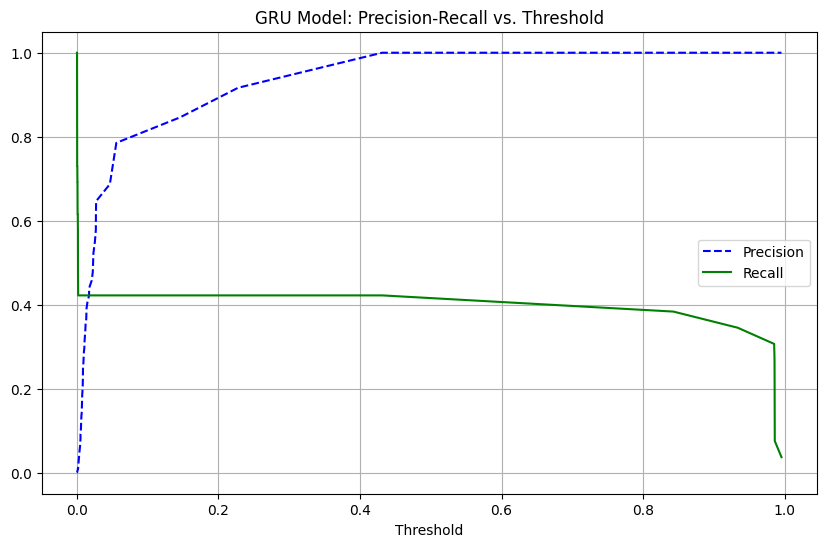

최적 임계값 (Best F1-score): 0.4313

--- Transformer 모델 최종 성능 평가 ---
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     17295
        True       1.00      0.42      0.59        26

    accuracy                           1.00     17321
   macro avg       1.00      0.71      0.80     17321
weighted avg       1.00      1.00      1.00     17321



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

# 1. 검증 데이터 준비
split_point = int(len(X) * 0.8)
X_val, y_val = X[split_point:], y[split_point:]

# 2. '폐업' 클래스의 예측 확률만 추출
y_pred_probs = model.predict(X_val)[:, closure_idx]

# 3. Precision-Recall 커브 계산 및 시각화
precisions, recalls, thresholds = precision_recall_curve(y_val == closure_idx, y_pred_probs)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.legend()
plt.title("GRU Model: Precision-Recall vs. Threshold")
plt.grid(True)
plt.show()

# 4. F1-score가 최대가 되는 최적 임계값으로 최종 성능 확인
f1_scores = 2 * recalls * precisions / (recalls + precisions + 1e-10)
best_threshold = thresholds[np.argmax(f1_scores[:-1])]
print(f"최적 임계값 (Best F1-score): {best_threshold:.4f}")

final_pred = (y_pred_probs >= best_threshold).astype(int)
print("\n--- Transformer 모델 최종 성능 평가 ---")
print(classification_report(y_val == closure_idx, final_pred))

In [ ]:
# '위기'로 간주할 이벤트들을 정의합니다.
crisis_events = {
    '폐업',
    '업종내순위_대폭악화',
    '상권내순위_대폭악화',
    'C0_핵심고객_이탈',
    'C2_초기우위_상실의심',
    'C3_고객구성_왜곡',
    'C5_단골확보_실패',
    'C7_내부역량_부족의심',
    'C9_운영_변동성_과다',
    'C10_타겟고객_설정오류'

}

# 정의한 위기 이벤트들의 숫자 인덱스를 미리 찾아둡니다.
crisis_indices = {event2idx[e] for e in crisis_events if e in event2idx}

In [ ]:
def predict_crisis_risk(store_sequence_str, model, event2idx, max_len, crisis_indices):
    """
    가맹점의 시퀀스를 입력받아,
    다음 달에 '위기 이벤트'가 발생할 종합 확률을 반환합니다.
    """
    # 1, 2, 3단계는 이전과 동일 (인코딩, 패딩, 예측)
    encoded_sequence = [event2idx.get(event, 0) for event in store_sequence_str]
    padded_sequence = pad_sequences([encoded_sequence], maxlen=max_len, padding='pre')
    prediction_probabilities = model.predict(padded_sequence, verbose=0)[0]

    # 4. '위기 이벤트'들의 확률을 모두 더합니다.
    total_crisis_score = sum(prediction_probabilities[idx] for idx in crisis_indices)

    return total_crisis_score

# --- 실행 예시 ---
target_store_index = 3939
sequence_to_predict = sequences.loc[target_store_index, 'event_sequence']
store_id_to_predict = sequences.loc[target_store_index, 'store_id']

print(f"--- 분석 대상 가맹점 [{store_id_to_predict}] ---")
print("이벤트 시퀀스:", sequence_to_predict)

# 3. 'predict_crisis_risk' 함수에 실제 시퀀스를 넣어 위험도를 계산합니다.
risk = predict_crisis_risk(sequence_to_predict, model, event2idx, max_len, crisis_indices)

print(f"\n>>> 해당 가맹점의 다음 달 '위기' 발생 종합 확률: {risk * 100:.2f}%")

--- 분석 대상 가맹점 [F12638FC09] ---
이벤트 시퀀스: ['일상', '업종내순위_개선', '업종내순위_개선', '업종내순위_개선', '일상', '일상', '일상', '일상', '일상', '일상', '일상', '일상', '일상']

>>> 해당 가맹점의 다음 달 '위기' 발생 종합 확률: 0.19%


In [ ]:
# '폐업' 이벤트가 포함된 시퀀스들만 추출
closed_sequences_df = sequences[sequences['event_sequence'].apply(lambda x: '폐업' in x)]

# 각 시퀀스에서 '일상'이 차지하는 비율을 계산
closed_sequences_df['일상_비율'] = closed_sequences_df['event_sequence'].apply(
    lambda x: x.count('일상') / (len(x) - 1) # 폐업 제외
)

# '일상' 비율이 매우 높은 (예: 90% 이상) 폐업 가맹점들을 확인
print(closed_sequences_df[closed_sequences_df['일상_비율'] >= 0.9])

        store_id                                     event_sequence     일상_비율
127   08336C3B85  [일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일...  1.000000
153   099CBF2425                               [일상, 일상, 일상, 일상, 폐업]  1.000000
157   09B5A19D91  [일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일...  1.000000
341   150889572A  [일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일...  0.916667
419   19DC3A560D  [일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일...  0.958333
...          ...                                                ...       ...
3884  EDDF492971  [일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일...  1.000000
3967  F27FC18E41  [일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일...  0.958333
4011  F5A4D98110  [일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일...  1.000000
4040  F7AB2719E7  [일상, 일상, 일상, 일상, 업종내순위_악화, 일상, 일상, 일상, 일상, 일상,...  0.958333
4149  FE30B6645E                                   [일상, 일상, 일상, 폐업]  1.000000

[69 rows x 3 columns]


/tmp/ipython-input-4120421451.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closed_sequences_df['일상_비율'] = closed_sequences_df['event_sequence'].apply(


- 시퀀스 데이터에 클러스터 넣고, 그 다음에 긍정 이벤트 넣기...?

# 5. 생존 이벤트 추가 => 망함

In [ ]:
# ==============================================================================
# 이벤트 생성 함수 정의
# ==============================================================================

def generate_event(row):
    events = []

    # --- 범용 이벤트 (순위 변화 기준) ---
    if row['rank_change'] > 5:
        events.append('업종내순위_악화')
    elif row['rank_change'] < -5:
        events.append('업종내순위_개선')

    # --- 핵심 위험 이벤트  ---
    # C0: 정통 한식 - 핵심 고객층(40대 남성) 이탈
    if row['cluster_id'] == 0 and row['male_40_ratio'] < 9.0:
        events.append('C0_핵심고객_이탈')

    # C2: 백반/가정식 - 초기 우위 상실 (순위 악화로 근사)
    # district_sales_rank_ratio_deterioration_count는 집계 지표이므로, 월별 순위가 크게 악화되는 현상으로 대체
    if row['cluster_id'] == 2 and row['district_rank_change'] > 15: # 15%p 이상 순위 악화 시
        events.append('C2_초기우위_상실의심')

    # C3: 소규모 분식 - 고객 구성 왜곡 (30대 남성 비중의 급격한 월별 증가로 근사)
    # male_30_ratio_start_end_diff는 집계 지표이므로, 전달 대비 비중 급증으로 대체
    if row['cluster_id'] == 3:
        # 이 규칙을 위해서는 'male_30_ratio_change' 컬럼이 사전에 계산되어야 합니다.
        # 예: df_merged['male_30_ratio_change'] = df_merged.groupby('store_id')['male_30_ratio'].diff()
        # 만약 해당 컬럼이 있다면 아래 주석을 해제하세요.
        # if row['male_30_ratio_change'] > 1.5:
        #    events.append('C3_고객구성_왜곡')
        # 대안: 30대 남성 비율이 비정상적으로 높은 경우
        if row['male_30_ratio'] > 20.0: # (예시 임계값, 데이터 분포를 보고 조정 필요)
            events.append('C3_고객구성_왜곡')

    # C5: 소형 커피 - 초기 고객 확보 실패 및 단골 부재
    if row['cluster_id'] == 5:
        if row['month_order'] <= 3 and row['female_30_ratio'] < 14.0:
            events.append('C5_초기핵심고객_부재')
        if row['month_order'] > 6 and row['returning_customer_ratio'] < 25.0:
            events.append('C5_단골확보_실패')

    # C7: 대형 카페 - 내부 경쟁력 상실 의심
    if row['cluster_id'] == 7 and row['industry_closure_ratio'] < 15.5:
        events.append('C7_내부경쟁력_상실의심')

    # C8: 마장동 시장 - 상권 환경 적응 실패 (상권 폐업률의 급격한 월별 감소로 근사)
    # district_closure_ratio_start_end_diff는 집계 지표이므로, 전달 대비 변화량으로 대체
    if row['cluster_id'] == 8:
        # 이 규칙을 위해서는 'district_closure_ratio_change' 컬럼이 사전에 계산되어야 합니다.
        # 예: df_merged['district_closure_ratio_change'] = df_merged.groupby('store_id')['district_closure_ratio'].diff()
        # 만약 해당 컬럼이 있다면 아래 주석을 해제하세요.
        # if row['district_closure_ratio_change'] < -0.5:
        #    events.append('C8_상권적응_실패의심')
        # 대안: 상권 폐업률이 매우 낮은데(안정적인데), 업종 내 순위가 악화될 경우
        if row['district_closure_ratio'] < 5.0 and row['rank_change'] > 5:
             events.append('C8_상권적응_실패의심')

    # C9: 단일 양식당 - 비정상적 운영 변동성 (순위 변동폭으로 근사)
    if row['cluster_id'] == 9 and abs(row['district_rank_change']) > 20: # 순위 변동폭이 20%p 이상일 때
        events.append('C9_운영_변동성_과다')

    # C10: 치킨/주류 - 장기 저항력 부족 (핵심 타겟 고객 설정 오류)
    if row['cluster_id'] == 10 and row['male_20_under_ratio'] > 20.0:
        events.append('C10_타겟고객_설정오류')

    if not events:
        return '일상'
    else:
        return '-'.join(sorted(events))


In [ ]:
# ==============================================================================
# 함수 적용 및 최종 시퀀스 데이터셋 생성
# ==============================================================================
# 1. 이벤트 생성
df_merged['event'] = df_merged.apply(generate_event, axis=1)

# 2. 가맹점별 시퀀스 생성
sequences = df_merged.groupby('store_id')['event'].apply(list).reset_index()
sequences.rename(columns={'event': 'event_sequence'}, inplace=True)

# 3. '폐업' 이벤트 추가
# is_closed 컬럼을 사용해 폐업한 가맹점 목록을 만듭니다.
closed_stores = set(df_merged[df_merged['is_closed'] == True]['store_id'])

sequences['event_sequence'] = sequences.apply(
    lambda row: row['event_sequence'] + ['폐업'] if row['store_id'] in closed_stores else row['event_sequence'] + ['생존'],
    axis=1
)

# 최종 결과 확인
print("--- 최종 시퀀스 데이터셋 ---")
print(sequences.head())

--- 최종 시퀀스 데이터셋 ---
     store_id                                     event_sequence
0  000F03E44A  [일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일...
1  002816BA73  [일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일...
2  003473B465  [일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일...
3  003AC99735  [일상, 일상, 일상, C5_초기핵심고객_부재, 일상, 일상, 일상, 일상, 일상,...
4  0041E4E5AE  [일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일상, 일...


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. 모든 이벤트를 모아 고유한 이벤트 사전을 만듭니다.
all_events = set(event for seq in sequences['event_sequence'] for event in seq)
event2idx = {event: i + 1 for i, event in enumerate(all_events)} # 0은 패딩을 위해 남겨둠
idx2event = {i + 1: event for i, event in enumerate(all_events)}

# '폐업' 이벤트의 번호를 따로 저장해 둡니다.
closure_idx = event2idx['폐업']
vocab_size = len(event2idx) + 1 # 패딩 포함한 전체 사전 크기

# 2. 모든 시퀀스를 정수(Integer)로 변환합니다.
encoded_sequences = [
    [event2idx[event] for event in seq]
    for seq in sequences['event_sequence']
]

# 3. 모든 시퀀스의 길이를 통일합니다 (Padding).
max_len = max(len(seq) for seq in encoded_sequences)
padded_sequences = pad_sequences(encoded_sequences, maxlen=max_len, padding='pre')

print("--- 정수 인코딩 및 패딩 완료 ---")
print("원본 시퀀스:", encoded_sequences[1])
print("패딩된 시퀀스:", padded_sequences[1])

--- 정수 인코딩 및 패딩 완료 ---
원본 시퀀스: [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14]
패딩된 시퀀스: [16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 14]


In [ ]:
import numpy as np

X = [] # 모델에 들어갈 입력 데이터
y = [] # 모델이 맞춰야 할 정답 데이터

for seq in padded_sequences:
    for i in range(1, len(seq)):
        # 0이 아닌 부분까지만 학습 데이터를 생성
        if seq[i] == 0:
            continue
        X.append(seq[:i])
        y.append(seq[i])

X = pad_sequences(X, maxlen=max_len, padding='pre')
y = np.array(y)

print("\n--- 학습 데이터셋 생성 ---")
print("입력 데이터 예시 (X):", X[-3:])
print("정답 데이터 예시 (y):", y[-3:])


--- 학습 데이터셋 생성 ---
입력 데이터 예시 (X): [[ 0  0  0 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
  16]
 [ 0  0 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
  16]
 [ 0 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
  16]]
정답 데이터 예시 (y): [16 16 14]


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense

# ==============================================================================
# 모델 정의
# ==============================================================================
# 모델의 각 층(Layer)을 순서대로 쌓아 만듭니다.

model = Sequential([
    # 1. Embedding Layer
    # 단어(이벤트)를 벡터로 변환하는 층입니다.
    # 모델이 이벤트 간의 의미적 관계를 학습하는 공간입니다.
    # input_dim: 전체 이벤트의 개수 (패딩 포함)
    # output_dim: 각 단어를 몇 차원의 벡터로 표현할지 (보통 64, 128 등)
    # input_length: 입력 시퀀스의 길이
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len),

    # 2. GRU Layer (Recurrent Neural Network)
    # 시퀀스 데이터의 시간적 패턴(순서)을 학습하는 핵심 층입니다.
    # units: GRU 레이어의 뉴런 수
    GRU(units=128),

    # 3. Dense Layer (Output Layer)
    # GRU에서 처리된 결과를 바탕으로 최종 예측을 수행합니다.
    # units: vocab_size -> 예측해야 할 이벤트의 총 개수
    # activation='softmax': 모든 이벤트에 대한 확률을 출력하여, 총합이 1이 되도록 만듭니다.
    Dense(units=vocab_size, activation='softmax')
])


# ==============================================================================
# 모델 컴파일
# ==============================================================================
# 모델을 어떻게 학습시킬지 설정합니다.
model.compile(
    optimizer='adam',  # 가장 일반적으로 사용되는 최적화 알고리즘
    loss='sparse_categorical_crossentropy', # 정수 형태의 정답(y)을 다룰 때 사용하는 손실 함수
    metrics=['accuracy'] # 학습 과정을 평가할 지표
)

# 모델의 전체 구조를 확인합니다.
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ==============================================================================
# 모델 학습
# ==============================================================================
# epochs: 전체 데이터셋을 몇 번 반복해서 학습할지
# batch_size: 한 번에 몇 개의 데이터를 묶어서 처리할지
history = model.fit(
    X,
    y,
    epochs=10,
    batch_size=64,
    validation_split=0.2 # 데이터의 20%를 검증용으로 사용
)

# 이제 'model'은 학습이 완료된 상태입니다.
# 이 모델을 사용하여 이전 단계에서 설명한 것처럼 '폐업 위험도'를 예측할 수 있습니다.

Epoch 1/10
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 39s 34ms/step - accuracy: 0.8700 - loss: 0.6288 - val_accuracy: 0.9176 - val_loss: 0.3265
Epoch 2/10
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - accuracy: 0.9198 - loss: 0.3145 - val_accuracy: 0.9183 - val_loss: 0.3094
Epoch 3/10
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 37s 33ms/step - accuracy: 0.9212 - loss: 0.3006 - val_accuracy: 0.9191 - val_loss: 0.3053
Epoch 4/10
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - accuracy: 0.9207 - loss: 0.2957 - val_accuracy: 0.9203 - val_loss: 0.3024
Epoch 5/10
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.9203 - loss: 0.2945 - val_accuracy: 0.9195 - val_loss: 0.3012
Epoch 6/10
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 35s 32ms/step - accuracy: 0.9208 - loss: 0.2946 - val_accuracy: 0.9202 - val_loss: 0.2995
Epoch 7/10
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 35s 32ms/step - accuracy: 0.9215 - loss: 0.2855 - val_accuracy: 0.9209 - val_loss: 0.2972
Epoch 8/10
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 34s 31ms/step - accuracy: 0.9192 -

549/549 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step


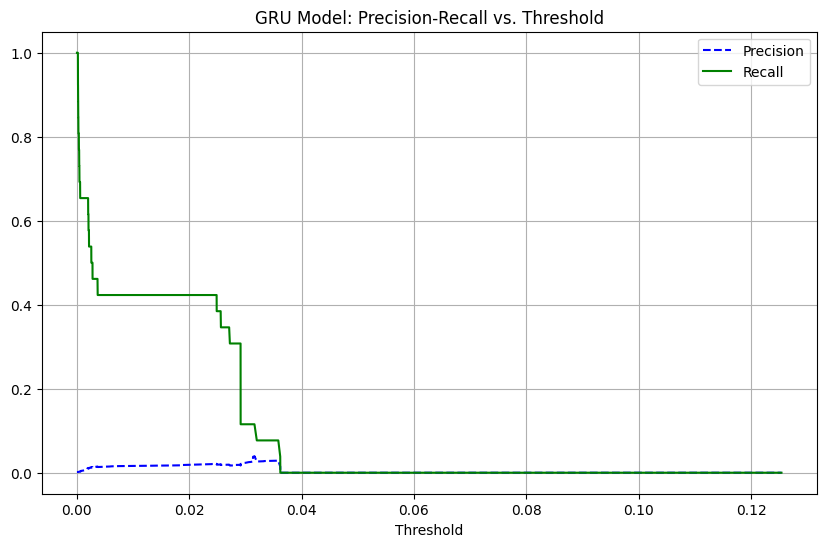

최적 임계값 (Best F1-score): 0.0316

--- GRU 모델 최종 성능 평가 ---
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     17511
        True       0.04      0.12      0.06        26

    accuracy                           0.99     17537
   macro avg       0.52      0.56      0.53     17537
weighted avg       1.00      0.99      1.00     17537



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

# 1. 검증 데이터 준비
split_point = int(len(X) * 0.8)
X_val, y_val = X[split_point:], y[split_point:]

# 2. '폐업' 클래스의 예측 확률만 추출
y_pred_probs = model.predict(X_val)[:, closure_idx]

# 3. Precision-Recall 커브 계산 및 시각화
precisions, recalls, thresholds = precision_recall_curve(y_val == closure_idx, y_pred_probs)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.legend()
plt.title("GRU Model: Precision-Recall vs. Threshold")
plt.grid(True)
plt.show()

# 4. F1-score가 최대가 되는 최적 임계값으로 최종 성능 확인
f1_scores = 2 * recalls * precisions / (recalls + precisions + 1e-10)
best_threshold = thresholds[np.argmax(f1_scores[:-1])]
print(f"최적 임계값 (Best F1-score): {best_threshold:.4f}")

final_pred = (y_pred_probs >= best_threshold).astype(int)
print("\n--- GRU 모델 최종 성능 평가 ---")
print(classification_report(y_val == closure_idx, final_pred))